Based on Perplexity suggested workflow + Z-scaler normalisation of ecg data

1. Load required libraries

In [4]:
import pandas as pd

import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt

import sklearn
print(sklearn.__version__)

import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical

1.26.4
1.5.2


2024-12-08 10:01:09.952903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


2. Load and prepare the data

In [5]:
import os
from pathlib import Path

# Assuming your CSV files are in a 'data' directory relative to your script
data_dir = Path('csvdata')
print(data_dir)



csvdata


In [6]:
def load_data(ecg_file, labels_file):
    ecg_signal = pd.read_csv(ecg_file, header=None).values.flatten()
    labels = pd.read_csv(labels_file)
    return ecg_signal, labels

def create_mask(ecg_signal, labels):
    mask = np.zeros(len(ecg_signal), dtype=int)
    for _, row in labels.iterrows():
        start, end = row['ROILimits_1'], row['ROILimits_2']
        value = row['Value']
        mask[start:end] = ['P', 'QRS', 'T'].index(value) + 1
    return mask

def resize_data(ecg_signal, mask, segment_length=5000):
    num_segments = len(ecg_signal) // segment_length
    ecg_segments = np.array_split(ecg_signal[:num_segments*segment_length], num_segments)
    mask_segments = np.array_split(mask[:num_segments*segment_length], num_segments)
    return np.array(ecg_segments), np.array(mask_segments)

# Passing very long input signals into the LSTM network can result in estimation performance degradation and excessive memory usage. 
# To avoid these effects, break the ECG signals and their corresponding label masks.
# create as many 5000-sample segments as possible and discard the remaining samples. 

# Normalise data
def normalise_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)


# Initialize empty lists:    
all_ecg_segments_norm = []
all_mask_segments_norm = []
#These lists will store the processed ECG segments and their corresponding masks.

# Load and process all files

for i in range(1, 211):  # Assuming 210 files
    ecg_file = data_dir / f'ecg{i}_ecgSignal.csv'
    labels_file = data_dir / f'ecg{i}_signalRegionLabels.csv'
    
    ecg_signal, labels = load_data(ecg_file, labels_file)
    ecg_signal_norm = normalise_signal(ecg_signal)
    mask = create_mask(ecg_signal_norm, labels)
    ecg_segments, mask_segments = resize_data(ecg_signal_norm, mask)
    
    all_ecg_segments_norm.extend(ecg_segments)  
    all_mask_segments_norm.extend(mask_segments)

# The processed segments are added to the respective lists.

# Convert to numpy arrays:
X_norm = np.array(all_ecg_segments_norm)
y_norm = np.array(all_mask_segments_norm)


Confirm and observe if normalisation is working using ecg1 file as an example

In [4]:
ecg1_signal = pd.read_csv(data_dir/'ecg1_ecgSignal.csv', header=None).values.flatten()
ecg1_labels = pd.read_csv(data_dir/'ecg1_signalRegionLabels.csv')
print(type(ecg1_signal))
print(type(ecg1_labels))
print(ecg1_signal[:5])
print(ecg1_signal.ndim)
print(ecg1_signal.shape)
print(ecg1_labels.head())

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
[-79 -77 -79 -81 -80]
1
(225000,)
   ROILimits_1  ROILimits_2 Value
0           83          117     P
1          130          153   QRS
2          201          246     T
3          285          319     P
4          332          357   QRS


In [5]:
ecg1_signal_norm = (ecg1_signal - np.mean(ecg1_signal)) / np.std(ecg1_signal)
print(type(ecg1_signal_norm))
print(ecg1_signal_norm[:5])
print(ecg1_signal_norm.ndim)
print(ecg1_signal_norm.shape)

<class 'numpy.ndarray'>
[-0.48891005 -0.43677202 -0.48891005 -0.54104809 -0.51497907]
1
(225000,)


3. Split the data into training and testing sets

test_size=0.3: This parameter specifies that 30% of the data should be allocated to the test set, while the remaining 70% will be used for training

random_state=42: This parameter sets a seed for the random number generator, ensuring that the split is reproducible. Using the same random_state will always produce the same split, which is crucial for reproducibility in machine learning experiments

In [7]:
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)


4. Prepare the data for LSTM

## one-hot encoding for categorical labels
One-hot encoding is a technique used to convert categorical variables into a format suitable for machine learning algorithms. It transforms categorical data into a binary representation, allowing models to process and interpret non-numeric information effectively.
How One-Hot Encoding Works
The process of one-hot encoding involves the following steps:
	1.	Identify unique categories within a categorical variable.
	2.	Create new binary columns, one for each unique category.
	3.	For each data point, assign a value of 1 in the column corresponding to its category and 0 in all other columns.

In [8]:
y_norm_train_cat = to_categorical(y_norm_train)
y_norm_test_cat= to_categorical(y_norm_test)

In [9]:
print("y_norm_train shape:", type(y_norm_train_cat), y_norm_train_cat.shape)
print("y_norm_train shape:", type(y_norm_train), y_norm_train.shape)
print("X_norm_train shape:", X_norm_train.shape)
print("y_norm_train_cat shape:", y_norm_train_cat.shape)


y_norm_train shape: <class 'numpy.ndarray'> (6542, 5000, 4)
y_norm_train shape: <class 'numpy.ndarray'> (6542, 5000)
X_norm_train shape: (6542, 5000)
y_norm_train_cat shape: (6542, 5000, 4)


5. Create and compile the LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Input, TimeDistributed

model_norm = Sequential([
    Input(shape=(5000, 1)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dense(4, activation='softmax')
])

model_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



6. Train the model

In [10]:
history = model_norm.fit(X_norm_train, y_norm_train_cat, validation_split=0.2, epochs=5, batch_size=32)




Epoch 1/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 920s 6s/step - accuracy: 0.6434 - loss: 0.9061 - val_accuracy: 0.8380 - val_loss: 0.3971
Epoch 2/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 915s 6s/step - accuracy: 0.8561 - loss: 0.3595 - val_accuracy: 0.8731 - val_loss: 0.3162
Epoch 3/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 877s 5s/step - accuracy: 0.8416 - loss: 0.4006 - val_accuracy: 0.8442 - val_loss: 0.3832
Epoch 4/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 871s 5s/step - accuracy: 0.8575 - loss: 0.3569 - val_accuracy: 0.8727 - val_loss: 0.3187
Epoch 5/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 4404s 27s/step - accuracy: 0.8719 - loss: 0.3217 - val_accuracy: 0.8819 - val_loss: 0.2984


Evaluate the model

In [12]:
test_loss, test_accuracy = model_norm.evaluate(X_norm_test, y_norm_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 944ms/step - accuracy: 0.8807 - loss: 0.2999
Test accuracy: 0.8809


In [13]:
print("Input shape:", model_norm.input_shape)
print("Output shape:", model_norm.output_shape)



Input shape: (None, 5000, 1)
Output shape: (None, 5000, 4)


Make predictions and visualize results

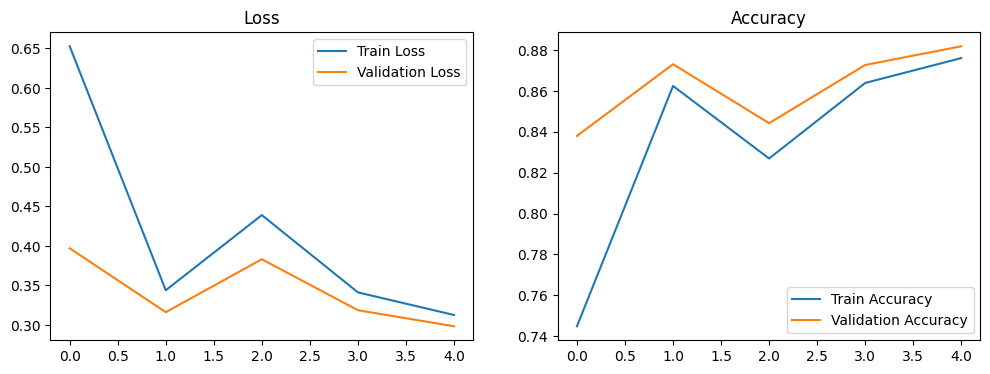

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


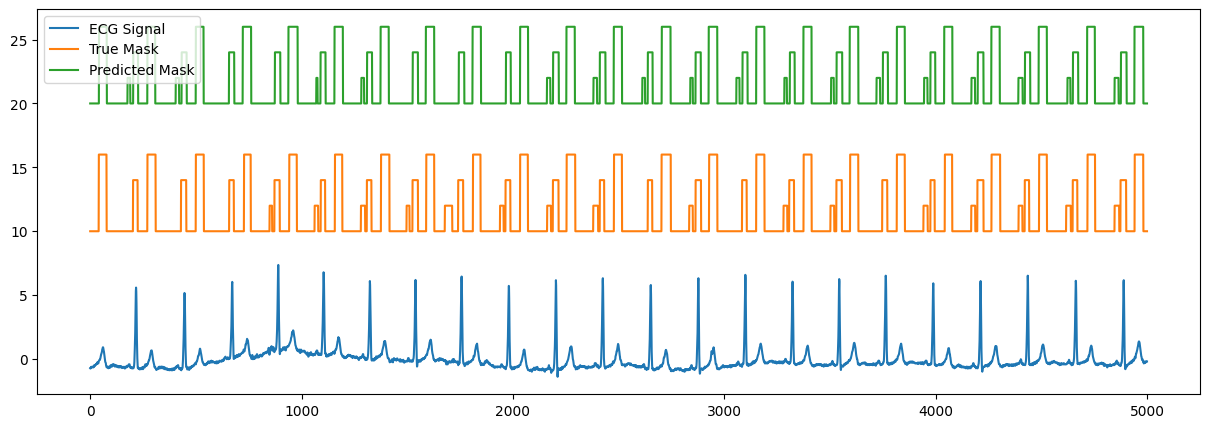

In [17]:
def plot_results(ecg_segment, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.plot(true_mask * 2+10, label='True Mask')
    plt.plot(predicted_mask * 2+20, label='Predicted Mask')
    plt.legend()
    plt.show()

# Make predictions on a test sample
sample_index = 0 #identifies which sample to test
sample_ecg = X_norm_test[sample_index]
sample_true_mask = y_norm_test[sample_index]
sample_predicted_mask = model_norm.predict(sample_ecg.reshape(1, 5000, 1))[0]
sample_predicted_mask = np.argmax(sample_predicted_mask, axis=1)

plot_results(sample_ecg, sample_true_mask, sample_predicted_mask)


In [78]:
print("model_norm Input shape:", model_norm.input_shape)
print("model_norm Output shape:", model_norm.output_shape)
print("model Input shape:", model.input_shape)
print("model Output shape:", model.output_shape)


model_norm Input shape: (None, 5000, 1)
model_norm Output shape: (None, 5000)
model Input shape: (None, 5000, 1)
model Output shape: (None, 5000, 4)


In [86]:
model.summary()
model_norm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 5000, 128)      │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 5000, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5000, 4)        │           260 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,268 (294.02 KB)

 Trainable params: 75,268 (294.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 5000, 128)      │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 5000, 64)       │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5000, 4)        │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,806 (882.06 KB)

 Trainable params: 75,268 (294.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,538 (588.04 KB)

In [96]:
print(type(y_norm_test))
print(y_norm_test.ndim)
print(y_norm_test[:5])

<class 'numpy.ndarray'>
2
[[0 0 0 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 2 2 2]
 [2 2 2 ... 3 3 3]]


In [101]:
print(type(y_norm_train))
print(y_norm_train.ndim)
print(y_norm_train[:5,])
print(y_norm_train.shape)

<class 'numpy.ndarray'>
2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 [0 0 0 ... 2 2 2]]
(6542, 5000)
